## Data preparation

In [7]:
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import umap
plt.rcParams.update({'font.size': 17})

#pd.set_option('display.max_columns', None)
df=pd.read_csv('Ravdess_TRAIN_cleaned.csv')
df

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,std,...,stft_sum_w4,stft_mean_w4,stft_std_w4,stft_min_w4,stft_q05_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,-0.703721,0.328567,-0.497301,...,0.135483,1.025697,-1.096766,-0.313562,1.421380,0.831973,0.536448,0.0,10.826275,-2.710136
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,-0.666674,0.272964,-0.482617,...,-0.196060,0.705437,-1.013205,2.191706,1.092210,0.441189,0.253557,0.0,0.064887,0.425032
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,-0.740767,0.337392,-0.441051,...,-0.307833,0.752290,-0.716367,-0.313562,0.899688,0.652634,0.569396,0.0,3.519767,-1.290314
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,-0.851860,0.318693,-0.451307,...,-0.607848,0.651498,-0.803778,1.593356,0.835496,0.515441,0.405521,0.0,0.218601,-0.015380
4,speech,calm,normal,Kids are talking by the door,1st,1,M,-0.444465,0.315162,-0.551542,...,0.145139,0.703301,-0.863050,1.335822,0.935801,0.549313,0.296205,0.0,1.260594,-0.448574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,speech,surprised,normal,Dogs are sitting by the door,2nd,18,F,-0.481488,-0.212894,-0.424693,...,-0.631100,0.143838,0.407872,-0.313562,-0.568068,0.320467,0.493310,0.0,1.457767,-1.346654
1824,speech,surprised,strong,Kids are talking by the door,1st,18,F,-0.333326,-0.186141,-0.248646,...,-0.887878,-0.194732,0.718169,-0.313562,-0.568068,0.139088,0.581452,0.0,-0.162612,-0.423159
1825,speech,surprised,strong,Kids are talking by the door,2nd,18,F,-0.444442,-0.314997,-0.189160,...,-0.910208,-0.057326,0.339948,-0.313562,-0.225264,0.022347,0.470287,0.0,0.128201,-0.378094
1826,speech,surprised,strong,Dogs are sitting by the door,1st,18,F,-0.074070,-0.088892,-0.070337,...,-0.445016,-0.136951,0.715166,-0.313562,-0.568068,0.207317,0.187007,0.0,0.356091,-0.924174


In [2]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#df.loc[:,"frame_count":"stft_skew_w4"] = scaler.fit_transform(df.loc[:,"frame_count":"stft_skew_w4"])

X, y = df.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df[["sex"]].values.flatten()

## Convex Hull

In [3]:
#depth base convex hull implementation
def convex_hull_outlier(k,df):
    points=df[["x","y"]].to_numpy()
    outliers_points=np.empty((2,2))
    for i in range(k):
        hull = ConvexHull(points)
        if i==0:
            outliers_points = hull.points[hull.vertices]
        else: 
            outliers_points = np.concatenate((outliers_points,hull.points[hull.vertices]))
        points=np.delete(points, hull.vertices,axis=0)
    outliers = list()
    for outlier in outliers_points:
        outliers.append(df[(X_reduced.x==outlier[0])&(df.y==outlier[1])].index.values[0])
    zeros=np.zeros(df.shape[0], dtype=int)
    np.put(zeros, outliers , 1)
    return zeros

In [4]:
#reduce space in 2 dimension
manifold = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.2,random_state=42).fit(X)
X_reduced = pd.DataFrame(manifold.transform(X)).rename(columns={0: 'x', 1: 'y'})

In [5]:
outliers=convex_hull_outlier(2,X_reduced)
X_reduced["outliers"] = outliers
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1804,   24], dtype=int64))

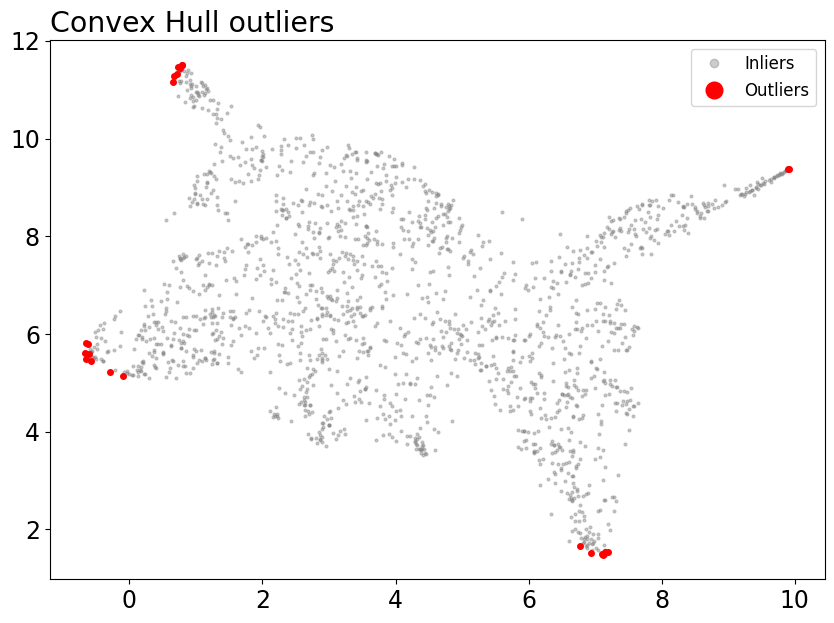

In [6]:
points = X_reduced[["x","y"]].to_numpy()

plt.figure(figsize=(10,7))
plt.plot( points[:,0], points[:,1], 'o', markersize=2, color="grey", alpha=0.4, label='Inliers')

for i in range(2):#cambiare il numero per cambiare la depth
    hull = ConvexHull(points)
    if i==0:
        plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'o', markersize=4, color="red" ,alpha=1,label="Outliers")
    else:
        plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'o', markersize=4, color="red" ,alpha=1)
    #for simplex in hull.simplices:
        #plt.plot(points[simplex, 0], points[simplex, 1], 'k--',linewidth=1)
    points=np.delete(points, hull.vertices,axis=0)

plt.legend(markerscale=3,fontsize="12")
plt.title('Convex Hull outliers', loc='left')
plt.show()

## KNN

In [89]:
from pyod.models.knn import KNN
clf = KNN(n_neighbors=35,method="mean")
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1671,  157], dtype=int64))

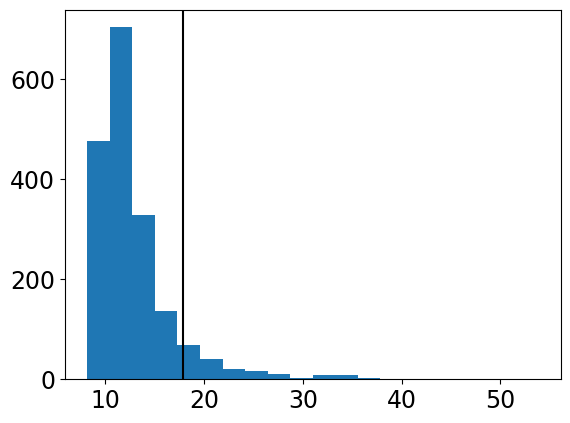

In [90]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [91]:
scores = clf.decision_scores_
top_percentile = np.percentile(scores, 99)
print(top_percentile)
outliers = scores >= top_percentile#top 1%outliers
np.unique(outliers, return_counts=True)

32.479273422482876


(array([False,  True]), array([1809,   19], dtype=int64))

In [92]:
manifold = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.2,random_state=42).fit(X)
X_reduced = pd.DataFrame(manifold.transform(X))
X_reduced["outliers"] = outliers
mapper = {True:"Outlier", False:"Inlier"}
X_reduced["outliers"] = X_reduced["outliers"].replace(mapper)
X_reduced.rename(columns={0: 'x', 1: 'y'}, inplace=True)

C:\Users\andri\AppData\Local\Temp\ipykernel_11296\3695016960.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
C:\Users\andri\AppData\Local\Temp\ipykernel_11296\3695016960.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')


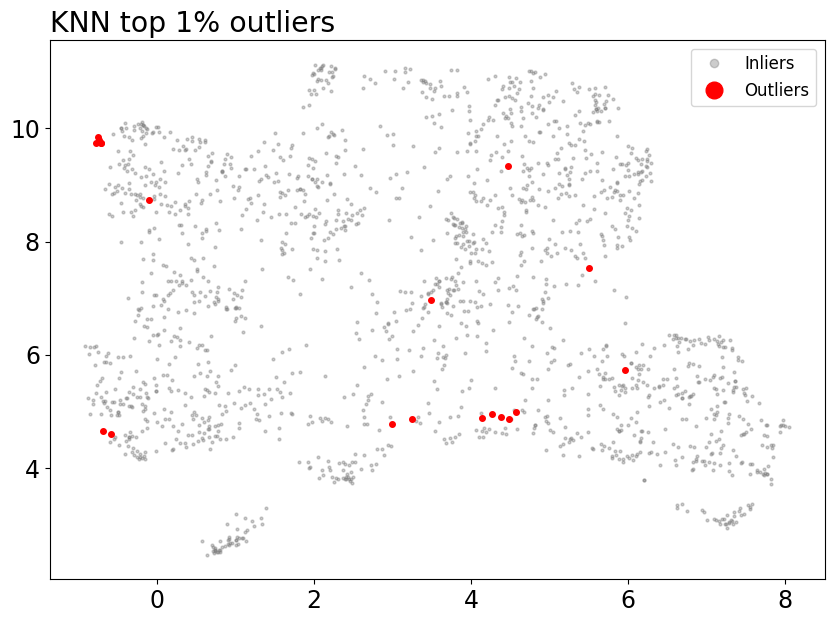

In [93]:
# Filter the data randomly
df_outliers = X_reduced[ X_reduced['outliers'] == 'Outlier']
df_inliers = X_reduced[ X_reduced['outliers'] == 'Inlier']
# Plot the whole dataset
plt.figure(figsize=(10,7))
plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
 
# Add the group to study
plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')
 
# Add titles and legend
plt.legend(markerscale=3,fontsize="12")
plt.title('KNN top 1% outliers', loc='left')

plt.show()

## LOF

In [13]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=35)            
outliers = clf.fit_predict(X)


np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  72, 1756], dtype=int64))

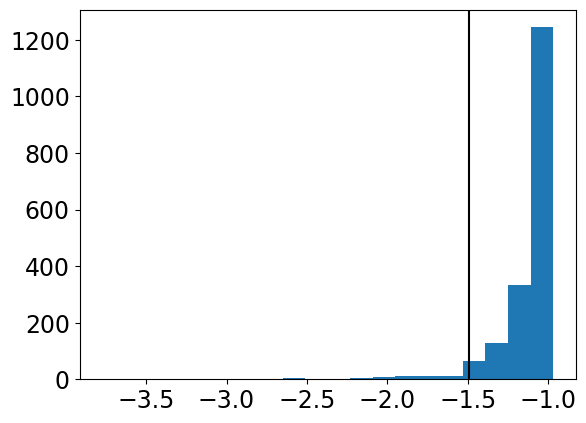

In [14]:
plt.hist(clf.negative_outlier_factor_, bins=20)
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(outliers==1)]), c='k')
plt.show()

In [15]:
lof_scores = clf.negative_outlier_factor_
top_percentile = np.percentile(lof_scores, 1)
outliers = lof_scores <= top_percentile#top 1%outliers
np.unique(outliers, return_counts=True)

(array([False,  True]), array([1809,   19], dtype=int64))

In [16]:
manifold = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.2,random_state=42).fit(X)
X_reduced = pd.DataFrame(manifold.transform(X))
X_reduced["outliers"] = outliers
mapper = {True:"Outlier", False:"Inlier"}
X_reduced["outliers"] = X_reduced["outliers"].replace(mapper)
X_reduced.rename(columns={0: 'x', 1: 'y'}, inplace=True)

C:\Users\andri\AppData\Local\Temp\ipykernel_6788\193753060.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
C:\Users\andri\AppData\Local\Temp\ipykernel_6788\193753060.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')


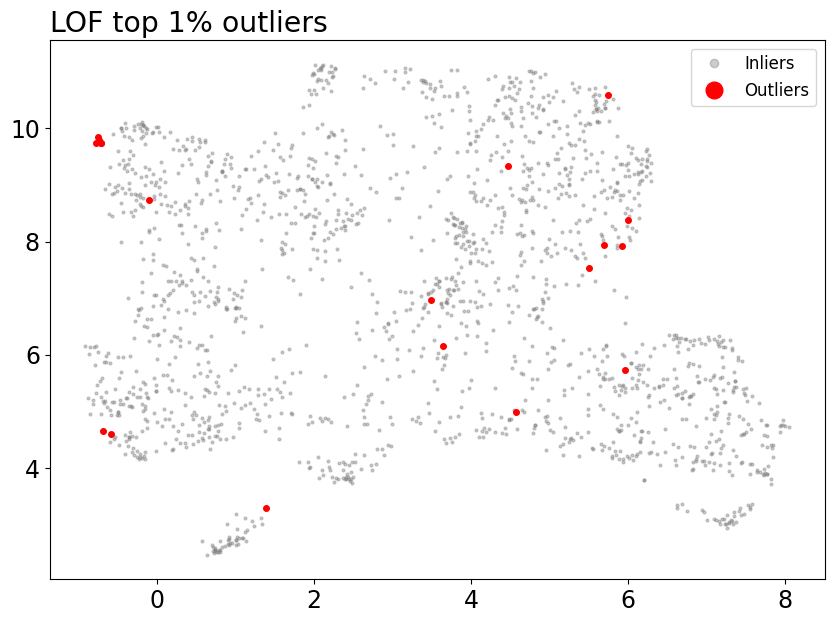

In [17]:
# Filter the data randomly
df_outliers = X_reduced[ X_reduced['outliers'] == 'Outlier']
df_inliers = X_reduced[ X_reduced['outliers'] == 'Inlier']
# Plot the whole dataset
plt.figure(figsize=(10,7))
plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
 
# Add the group to study
plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')
 
# Add titles and legend
plt.legend(markerscale=3,fontsize="12")
plt.title('LOF top 1% outliers', loc='left')

plt.show()

## ABOD

In [100]:
from pyod.models.abod import ABOD
clf = ABOD()
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1600,  228], dtype=int64))

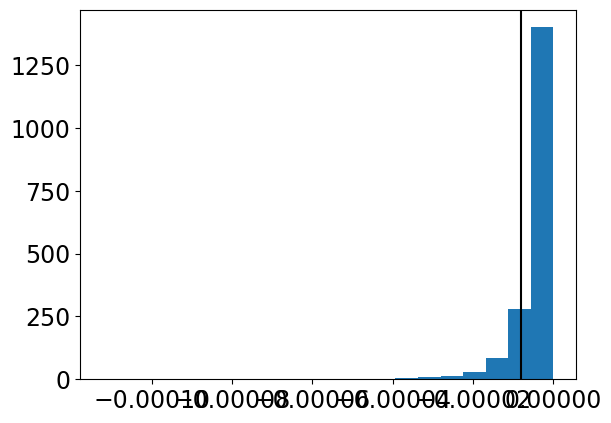

In [39]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [101]:
scores = clf.decision_scores_
top_percentile = np.percentile(scores, 1)
print(top_percentile)
outliers = scores <= top_percentile#top 1%outliers
np.unique(outliers, return_counts=True)

-2.846520145987204e-05


(array([False,  True]), array([1809,   19], dtype=int64))

In [41]:
manifold = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.2,random_state=42).fit(X)
X_reduced = pd.DataFrame(manifold.transform(X))
X_reduced["outliers"] = outliers
mapper = {True:"Outlier", False:"Inlier"}
X_reduced["outliers"] = X_reduced["outliers"].replace(mapper)
X_reduced.rename(columns={0: 'x', 1: 'y'}, inplace=True)

C:\Users\andri\AppData\Local\Temp\ipykernel_11296\2193337829.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
C:\Users\andri\AppData\Local\Temp\ipykernel_11296\2193337829.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')


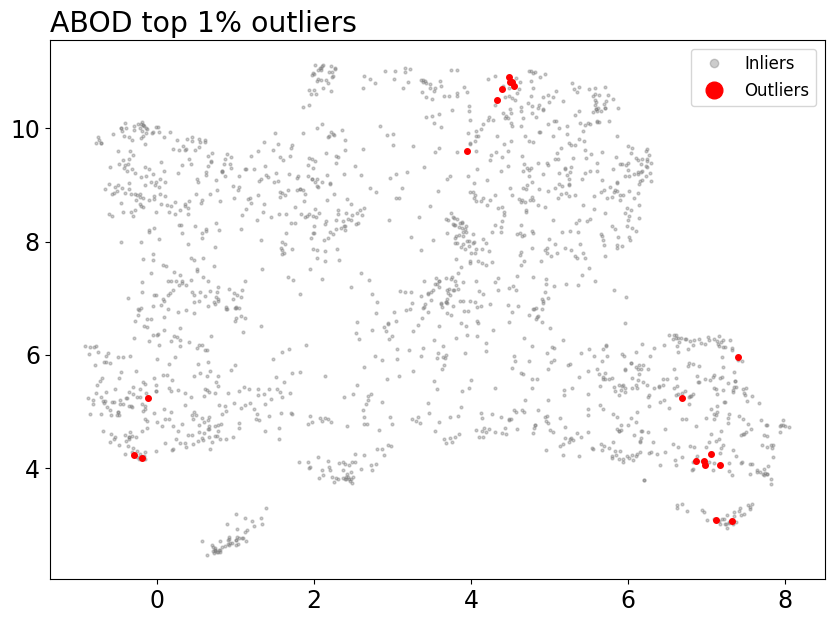

In [42]:
# Filter the data randomly
df_outliers = X_reduced[ X_reduced['outliers'] == 'Outlier']
df_inliers = X_reduced[ X_reduced['outliers'] == 'Inlier']
# Plot the whole dataset
plt.figure(figsize=(10,7))
plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
 
# Add the group to study
plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')
 
# Add titles and legend
plt.legend(markerscale=3,fontsize="12")
plt.title('ABOD top 1% outliers', loc='left')

plt.show()

## Isolation forest

In [46]:
from pyod.models.iforest import IsolationForest
clf = IsolationForest(random_state=42)
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  61, 1767], dtype=int64))

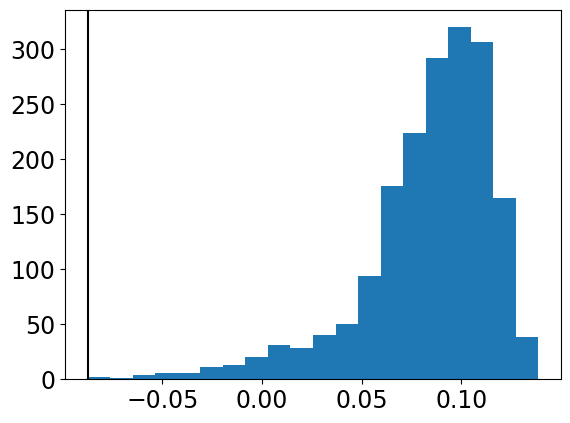

In [47]:
plt.hist(clf.decision_function(X), bins=20)
plt.axvline(np.min(clf.decision_function(X)[np.where(outliers==-1)]), c='k')
plt.show()

In [32]:
clf.decision_function(X)[np.where(outliers==-1)]

61

In [48]:
scores = clf.decision_function(X)
top_percentile = np.percentile(scores, 1)
print(top_percentile)
outliers = scores <= top_percentile#top 1%outliers
np.unique(outliers, return_counts=True)

-0.03091128663730247


(array([False,  True]), array([1809,   19], dtype=int64))

In [44]:
manifold = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.2,random_state=42).fit(X)
X_reduced = pd.DataFrame(manifold.transform(X))
X_reduced["outliers"] = outliers
mapper = {True:"Outlier", False:"Inlier"}
X_reduced["outliers"] = X_reduced["outliers"].replace(mapper)
X_reduced.rename(columns={0: 'x', 1: 'y'}, inplace=True)

C:\Users\andri\AppData\Local\Temp\ipykernel_63092\2173267730.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
C:\Users\andri\AppData\Local\Temp\ipykernel_63092\2173267730.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')


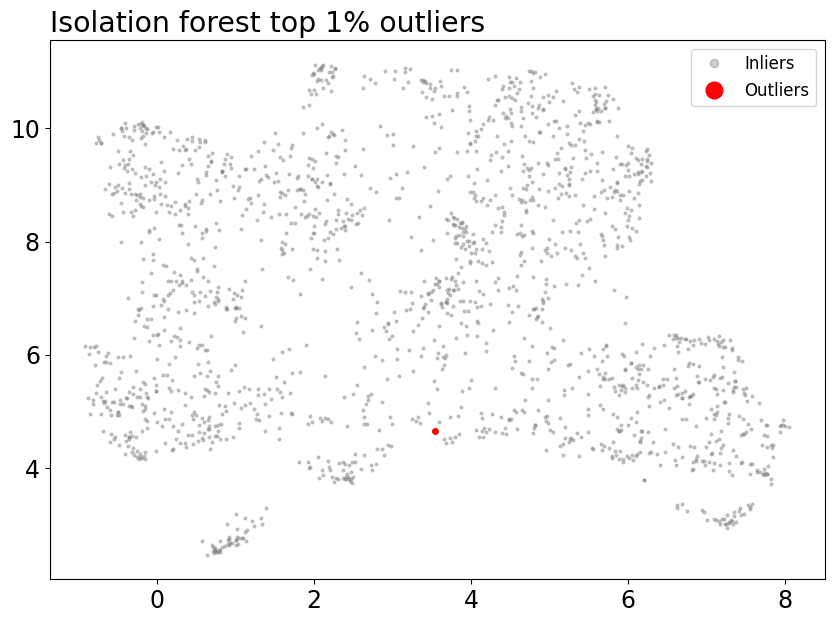

In [45]:
# Filter the data randomly
df_outliers = X_reduced[ X_reduced['outliers'] == 'Outlier']
df_inliers = X_reduced[ X_reduced['outliers'] == 'Inlier']
# Plot the whole dataset
plt.figure(figsize=(10,7))
plt.plot( 'x', 'y', "", data=df_inliers, linestyle='', marker='o', markersize=2, color="grey", alpha=0.4, label='Inliers')
 
# Add the group to study
plt.plot( 'x', 'y', "", data=df_outliers, linestyle='', marker='o', markersize=4, color="red" ,alpha=1, label='Outliers')
 
# Add titles and legend
plt.legend(markerscale=3,fontsize="12")
plt.title('Isolation forest top 1% outliers', loc='left')

plt.show()

# Effect of removing outlier (through classifier result)

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## KNN With outliers

In [78]:
#WITH OUTLIER
clf = KNeighborsClassifier(n_neighbors=35)
y_pred_knn = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred_knn, digits=3))


              precision    recall  f1-score   support

           F      0.942     0.978     0.960       268
           M      0.978     0.943     0.960       281

    accuracy                          0.960       549
   macro avg      0.960     0.960     0.960       549
weighted avg      0.961     0.960     0.960       549



## DT With outliers

In [79]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
y_pred_dt =clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred_dt, digits=3))

              precision    recall  f1-score   support

           F      0.931     0.899     0.915       268
           M      0.907     0.936     0.921       281

    accuracy                          0.918       549
   macro avg      0.919     0.918     0.918       549
weighted avg      0.918     0.918     0.918       549



## Outlier detectors

### Iso Forest

In [76]:
from pyod.models.iforest import IsolationForest
clf = IsolationForest().fit(X)

# Compute anomaly scores and find top 1% outliers
scores = clf.decision_function(X)
top_percentile = np.percentile(scores, 1)
outliers = np.where(scores <= top_percentile)[0]

# Remove outliers
df_clean = df.drop(outliers)

# Reset the index
df_clean = df_clean.reset_index(drop=True)

### LOF

In [35]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=35, algorithm='auto', metric='euclidean', contamination=0.1)
clf.fit(X)

# Compute anomaly scores and find top 1% outliers
lof_scores = clf.negative_outlier_factor_
top_percentile = np.percentile(lof_scores, 1)
outliers = np.where(lof_scores <= top_percentile)[0]

# Remove outliers
df_clean = df.drop(outliers)

# Reset the index
df_clean = df_clean.reset_index(drop=True)

### ABOD

In [80]:
from pyod.models.abod import ABOD
clf = ABOD()
clf.fit(X)

# Compute anomaly scores and find top 1% outliers
scores = clf.decision_scores_
top_percentile = np.percentile(scores, 1)
outliers = np.where(scores <= top_percentile)[0]

# Remove outliers
df_clean = df.drop(outliers)

# Reset the index
df_clean = df_clean.reset_index(drop=True)

### KNN outliers

In [50]:
from pyod.models.knn import KNN
clf = KNN(n_neighbors=35)
clf.fit(X)

# Compute anomaly scores and find top 1% outliers
scores = clf.decision_scores_
top_percentile = np.percentile(scores, 1)
outliers = np.where(scores <= top_percentile)[0]

# Remove outliers
df_clean = df.drop(outliers)

# Reset the index
df_clean = df_clean.reset_index(drop=True)

In [81]:
X_clean, y_clean = df_clean.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df_clean[["sex"]].values.flatten()
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean)

## Without outliers

In [82]:
#WITHOUT OUTLIER
clf = KNeighborsClassifier(n_neighbors=30)

y_pred_clean_knn = clf.fit(X_train_clean, y_train_clean).predict(X_test_clean)

clf = DecisionTreeClassifier(min_samples_leaf=3)

y_pred_clean_dt = clf.fit(X_train_clean, y_train_clean).predict(X_test_clean)



print("---------------------------- KNN ----------------------------\n")
print("WITH OULIERS-------------------------------------------------\n")
print(classification_report(y_test, y_pred_knn, digits=3))
print("WITHOUT OULIERS----------------------------------------------\n")
print(classification_report(y_test_clean, y_pred_clean_knn, digits=3))
print("\n\n\n---------------------------- DT ----------------------------\n")
print("WITH OULIERS-------------------------------------------------\n")
print(classification_report(y_test, y_pred_dt, digits=3))
print("WITHOUT OULIERS----------------------------------------------\n")
print(classification_report(y_test_clean, y_pred_clean_dt, digits=3))

---------------------------- KNN ----------------------------

WITH OULIERS-------------------------------------------------

              precision    recall  f1-score   support

           F      0.942     0.978     0.960       268
           M      0.978     0.943     0.960       281

    accuracy                          0.960       549
   macro avg      0.960     0.960     0.960       549
weighted avg      0.961     0.960     0.960       549

WITHOUT OULIERS----------------------------------------------

              precision    recall  f1-score   support

           F      0.956     0.981     0.969       267
           M      0.981     0.957     0.969       276

    accuracy                          0.969       543
   macro avg      0.969     0.969     0.969       543
weighted avg      0.969     0.969     0.969       543




---------------------------- DT ----------------------------

WITH OULIERS-------------------------------------------------

              precision    re